In [1]:
#import
import numpy as np
import math
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint   
import sys
torch.set_default_dtype(torch.float64)

In [39]:
#Load data 
# Here:
# Num_atom_qm  = 14
# Num_atom_all = 6041
# Num_config   = 1000
Num_atom = 14  
Num_atom_all = 6041 
Num_config = 1000
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device

Energy = torch.from_numpy(np.array(np.load("energy.npy"), dtype="float64")) #[1000]
atom_types = torch.from_numpy(np.array(np.load("element.npy"), dtype="float64")) #Atom_type [6041]
qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float64"))#QM_coord [1000,14,3]
mm_coords = torch.from_numpy(np.array(np.load("env_coord.npy"), dtype="float64")) #QM_coord [1000,6041-14,3]

atom_types = torch.from_numpy(np.array(np.load("element.npy"), dtype="float64")) #Atom_type [6041]
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types[:Num_atom]])).to(device)
atom_types = atom_types.repeat(len(qm_coord), 1).long()

train_ratio = 0.95
validation_ratio = 0.05

Num_train = int(Num_config * train_ratio) # Number of training set
Num_valid = Num_config-Num_train

charge_of_water = [-0.834, 0.417, 0.417] # 0 and H
Charge_water = torch.Tensor(np.repeat(np.array(charge_of_water), int((Num_atom_all-Num_atom)/3)).reshape(3,-1).swapaxes(1,0).reshape(-1))


In [40]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij
def wise_vector(coords:Tensor,mm_coords:Tensor ) -> Tensor:
    #print(coords.shape,mm_coords.shape)
    rij_2 = coords[:, :, None] - mm_coords[:, None]
    #print(rij_2.shape)
    return rij_2


def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    sij = dij/Rcr
    fij = (torch.cos(torch.where(sij>1,1,sij) * math.pi) + 1) * 0.5

    g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=1) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=1))**2) * fij.unsqueeze(dim=-1), dim=2)

    return g2

def symmetry_function_g3(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    
    s12 = d12/Rca
    s13 = d13/Rca
    s23 = d23/Rca
    f12 = (torch.cos( torch.where(s12>1,1,s12) * math.pi) + 1) * 0.5
    f13 = (torch.cos(torch.where(s13>1,1,s13)  * math.pi) + 1) * 0.5
    f23 = (torch.cos(torch.where(s23>1,1,s23)  * math.pi) + 1) * 0.5

    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    xx=2*2**(1 - Zeta.unsqueeze(dim=1)) * ((1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=1)) * torch.exp(-EtaA.unsqueeze(dim=1) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1)
    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * ((1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=1)) * torch.exp(-EtaA.unsqueeze(dim=1) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)

    return g3
def symmetry_function_gw(rij_env: Tensor,Chargewater:Tensor) -> Tensor:
    dij_env = torch.norm(rij_env, dim=3)
    gw=torch.sum(Charge_water/dij_env,dim=2).unsqueeze(dim=-1)
    return gw    


In [41]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)

    def forward(self, coords: Tensor, atom_types: Tensor,mm_coords:Tensor,Charge_water:Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        rij_env=wise_vector(coords,mm_coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3(rij, self.Rca, Zeta, EtaA)
        gw = symmetry_function_gw(rij_env,Charge_water)
        result=torch.concat((g2,g3,gw), dim=2)
        
        fmax,_ = torch.max(result,0)
        fmax = fmax.unsqueeze(dim=0)
        fmin,_ = torch.min(result,0)
        fmin =fmin.unsqueeze(dim=0)
        
        result=2*(result-fmin)/(fmax-fmin+1.0e-32)-1 #o
        return result

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])+1

In [42]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input


class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        #print(x.shape,channels.shape)
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)


        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )
class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

In [43]:
class BPNN(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate
    
    def printFeature(self, coords: torch.Tensor, atom_types: torch.Tensor,mm_coords: torch.Tensor,Charge_water:torch.Tensor):
        descriptors = self.descriptor(coords, atom_types,mm_coords,Charge_water)
        return descriptors

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor,mm_coords: torch.Tensor,Charge_water:torch.Tensor):
        descriptors = self.descriptor(coords, atom_types,mm_coords,Charge_water)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        return torch.hstack(energy)

    def training_step(self, batch, batch_idx):
        qm_coord,mm_coords, atom_types, energy= batch
        ene_pred= self(qm_coord, atom_types[0],mm_coords,Charge_water)
        ene_loss = F.mse_loss(ene_pred, energy)
        loss=ene_loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord,mm_coords, atom_types, energy= batch
        ene_pred= self(qm_coord, atom_types[0],mm_coords,Charge_water)
        ene_loss = F.mse_loss(ene_pred, energy)
        loss = ene_loss
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.97),
                     'interval': 'epoch',
                     'frequency': 5,
                    }
        return [optimizer], [scheduler]

In [44]:

pl.seed_everything(2)
dataset = TensorDataset(qm_coord,mm_coords, atom_types, Energy)
train,val = random_split(dataset,[Num_train,Num_valid])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

Global seed set to 2


In [57]:
#run
Rcr = 6.0
Rca =6.0
ShfR = [element*0.5291772 for element in [2.0,4.0,6.0, 8.0, 10.0]]
EtaA = [element/0.5291772**2 for element in [5.00, 0.40, 0.10, 0.03, 0.01]]
EtaR = [element/0.5291772**2 for element in [5.00,0.40, 0.10, 0.03, 0.01]]
ShfA = [0.0]
Zeta = [14.0]
EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
Zeta, EtaA, ShfA = np.array(np.meshgrid(Zeta, EtaA, ShfA)).reshape(3, -1)
EtaR = np.repeat([EtaR], 3, axis=0)
ShfR = np.repeat([ShfR], 3, axis=0)
Zeta = np.repeat([Zeta], 3, axis=0)
EtaA = np.repeat([EtaA], 3, axis=0)
ShfA = np.repeat([ShfA], 3, axis=0)
descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA)



fitting_net = Fitting(3, descriptor.output_length, neuron=[15])
model = BPNN(descriptor, fitting_net, learning_rate=1e-2)
#Fx=model.printFeature(qm_coord.cpu(), atom_types[0].cpu(),mm_coords,Charge_water)
from pytorch_lightning.callbacks import ModelCheckpoint  
checkpoint_callback = ModelCheckpoint(save_top_k = -1, save_last = False, every_n_epochs = 1)#100 epochs to save once 
csv_logger = pl_loggers.CSVLogger('logs_csv/', flush_logs_every_n_steps = 10)


#trainer = pl.Trainer(max_epochs=500, logger=csv_logger, log_every_n_steps=20, accelerator='gpu')
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, log_every_n_steps=1, accelerator='auto',callbacks = [checkpoint_callback])
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type    | Params
----------------------------------------
0 | descriptor  | Feature | 0     
1 | fitting_net | Fitting | 1.5 K 
----------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\wjn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.

In [63]:
#model load

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    #print(param_tensor, "\t", model.state_dict()[param_tensor])


TypeError: Feature.forward() missing 2 required positional arguments: 'mm_coords' and 'Charge_water'

300
10


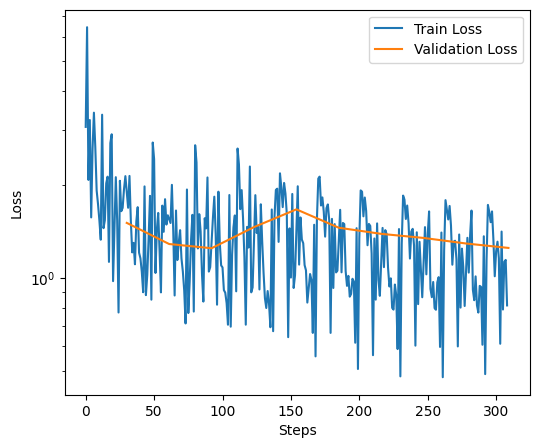

In [50]:
data = pd.read_csv('logs_csv/lightning_logs/version_2/metrics.csv')
# data = pd.read_csv('/content/drive/MyDrive/f10_e500/logs_csv/lightning_logs/version_2/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Train Loss')
y = data['valid_loss'][~data['valid_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

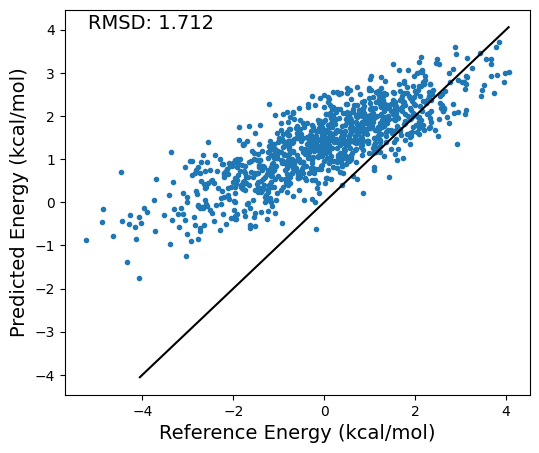

In [51]:

ene_pred= model(qm_coord.cpu(), atom_types[0].cpu(),mm_coords,Charge_water)

fig, ax = plt.subplots(figsize=(6,5))


e1=Energy.cpu().detach().numpy()
e2=ene_pred.cpu().detach().numpy()

ax.plot(e1, e2, linestyle='none', marker='.', )
ax.plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax.set_xlabel("Reference Energy (kcal/mol)", size=14)
ax.set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax.annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)


plt.savefig('rmsd.png', dpi=300)